In [1]:
import numpy as np
import pandas as pd
import torch
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

import pickle


%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import DataLoader, Dataset

import numpy as np
from datasets import DatasetDict
from datasets import load_dataset, load_metric, concatenate_datasets

from hw3 import training


from cs236781.plot import plot_fit
from cs236781.train_results import FitResult

$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 4: Fine-Tuning a pretrained language model
<a id=part3></a>

In this part , we will deal with the fine-tuning of BERT for sentiment analysis on the IMDB movie reivews dataset from the previous section.   
BERT is a large language model developed by Google researchers in 2019 that offers a good balance between popularity and model size, which can be fine-tuned using a simple GPU.  

If you aren't yet familiar, you can check it out here:  
https://arxiv.org/pdf/1810.04805.pdf.
(Read Section 3 for details on the model architecture and fine-tuning on downstream tasks).

In particular, we will use the distilled (smaller) version of BERT, called Distil-BERT.
Distil-BERT is widely used in production since it has 40% fewer parameters than BERT, while running 60% faster and retaining 95% of the performance in many benchmarks.
It is recommended to glance through the Distil-BERT paper to get a feel for the model architecture and how it differs from BERT: 
https://arxiv.org/pdf/1910.01108.pdf

We will download a pre-trained `Distil-BERT` from `Hugging Face`, so there is no need to train it from scratch. 

One of the key strengths of Hugging Face is its extensive collection of pre-trained models. These models are trained on large-scale datasets and exhibit impressive performance on various NLP tasks, such as text classification, named entity recognition, sentiment analysis, machine translation, and question answering, among others. The pre-trained models provided by Hugging Face can be easily fine-tuned for specific downstream tasks, saving significant time and computational resources.  


## Loading the Dataset

We will now load and prepare the IMDB dataset as we did in the previous part.  
Here we will load the full training and test set.


In [3]:
dataset = load_dataset('imdb', split=['train', 'test[12260:12740]'])

In [4]:
print(dataset)

[Dataset({
    features: ['text', 'label'],
    num_rows: 25000
}), Dataset({
    features: ['text', 'label'],
    num_rows: 480
})]


In [5]:
#wrap it in a DatasetDict to enable methods such as map and format
dataset = DatasetDict({'train': dataset[0], 'test': dataset[1]})

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 480
    })
})

We can now access the datasets in the Dict as we would a dictionary.
Let's print a few training samples

In [7]:
for i in range(4):
    print(f'TRAINING SAMPLE {i}:') 
    print(dataset['train'][i]['text'])
    label = dataset['train'][i]['label']
    print(f'Label {i}: {label}')
    print('\n')

TRAINING SAMPLE 0:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few a

We should also check the label distribution:

In [8]:
def label_cnt(type):
    ds = dataset[type]
    size = len(ds)
    cnt= 0 
    for smp in ds:
        cnt += smp['label']
    print(f'negative samples in {type} dataset: {size - cnt}')
    print(f'positive samples in {type} dataset: {cnt}')
    
label_cnt('train')
label_cnt('test')

negative samples in train dataset: 12500
positive samples in train dataset: 12500
negative samples in test dataset: 240
positive samples in test dataset: 240


### __Import the tokenizer for the dataset__


We will now tokenize the text the same way we did in the previous part.



In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
print("Tokenizer input max length:", tokenizer.model_max_length)
print("Tokenizer vocabulary size:", tokenizer.vocab_size)

Tokenizer input max length: 512
Tokenizer vocabulary size: 30522


In [10]:
def tokenize_text(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

def tokenize_dataset(dataset):
    dataset_tokenized = dataset.map(tokenize_text, batched=True, batch_size =None)
    return dataset_tokenized

dataset_tokenized = tokenize_dataset(dataset)
# we would like to work with pytorch so we can manually fine-tune
dataset_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# no need to parrarelize in this assignment
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Setting up the dataloaders and dataset

We will now set up the dataloaders for efficient batching and loading of the data.  
By now, you are familiar with the Class methods that are needed to create a working Dataloader.


In [11]:
class IMDBDataset(Dataset):
    def __init__(self, dataset):
        self.ds = dataset

    def __getitem__(self, index):
        return self.ds[index]

    def __len__(self):
        return self.ds.num_rows

In [12]:
train_dataset = IMDBDataset(dataset_tokenized['train'])
test_dataset = IMDBDataset(dataset_tokenized['test'])

In [13]:

n_workers= 0

dl_train,dl_test = [ 
    DataLoader(
    dataset=train_dataset,
    batch_size=12,
    shuffle=True, 
    num_workers=n_workers
),
DataLoader(
    dataset=test_dataset,
    batch_size=12,
    shuffle=False,
    num_workers=n_workers
)]

In [14]:
dl_train

## Importing the model from Hugging Face
We will now  delve into the process of loading the DistilBERT model from `Hugging Face`. DistilBERT is a distilled version of the BERT model, offering a lighter and faster alternative while retaining considerable performance on various NLP tasks.  
Please refer to the introduction to check out the relevant papers.  
For more info on how to use this model, feel free to check it out on the site:  
https://huggingface.co/distilbert-base-uncased 



To begin, we will import the necessary library required for our implementation.
It is fine if you receive a warning from `Hugging Face` to train the model on a downstream task, which is exactly what we will do on our IMDB dataset. 

In [15]:
from transformers import AutoModelForSequenceClassification


In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


__Let's print the model architecture to see what we are dealing with:__

In [17]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

## Fine Tuning
We will now move on to the process of fine-tuning the model that we previously loaded from `Hugging Face`. Fine-tuning allows us to adapt the pre-trained model to our specific NLP task by further training it on task-specific data. This process enhances the model's performance and enables it to make more accurate predictions on our target task.  

There are generally two approaches to fine-tuning the loaded model, each with its own advantages and considerations:  

1) __Freeze all the weights besides the last two linear layers and train only those layers__:  
This approach is commonly referred to as "transfer learning" or "feature extraction." By freezing the weights of the majority of the model's layers, we retain the pre-trained knowledge captured by the model, allowing it to extract useful features from our data. We then replace and train the final few layers, typically linear layers, to adapt the model to our specific task. This method is beneficial when we have limited labeled data or when the pre-trained model has been trained on a similar domain.

2) __Retrain all the parameters in the model__:  
This approach involves unfreezing and training all the parameters of the loaded model, including the pre-trained layers. By retraining all the parameters, we allow the model to adjust its representations and update its knowledge based on our specific task and data. This method is often preferred when we have sufficient labeled data available and want the model to learn task-specific features from scratch or when the pre-trained model's knowledge may not be directly applicable to our domain.

### Fine-tuning method 1 
__Freeze all the weights besides the last two linear layers and train only those layers__



In [18]:
# TODO:
# Freeze all parameters except for the last 2 linear layers
# ====== YOUR CODE: ======
for name, param in model.named_parameters():
    if 'pre_classifier' not in name and 'classifier' not in name:
        param.requires_grad = False

# ========================

# HINT: use the printed model architecture to get the layer names




### Training 
We can use our abstract __Trainer__ class to fine-tune the model:
We will not play around with hyperparameters in this section, as the point is to learn to fine-tune a model.   
In addition, we do not need to send our own loss function for this loaded model (try to understand why).   

__TODO__: Implement the `FineTuningTrainer` in `hw3/training.py`

We will train the model for 2 epochs of 40 batches.  
You can run this either locally or on the course servers, whichever is most comfortable for you.

In [19]:
from hw3 import training

optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5)

# fit your model
if not os.path.exists('finetuned_last_2.pt'):
    trainer = training.FineTuningTrainer(model, loss_fn = None, optimizer = optimizer)
    fit_result = trainer.fit(dl_train,dl_test, checkpoints='finetuned_last_2', num_epochs=2, max_batches= 40)
    with open('fit_result_finetune_2.pkl', 'wb') as f:
        pickle.dump(fit_result, f)
    

saved_state = torch.load('finetuned_last_2.pt')
model.load_state_dict(saved_state['model_state']) 
best_acc = saved_state['best_acc']
print('best acc:', best_acc)

with open('fit_result_finetune_2.pkl', 'rb') as f:
    fit_result = pickle.load(f) 



best acc: 79.16666666666667


(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <Axes: title={'center': 'test_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'test_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

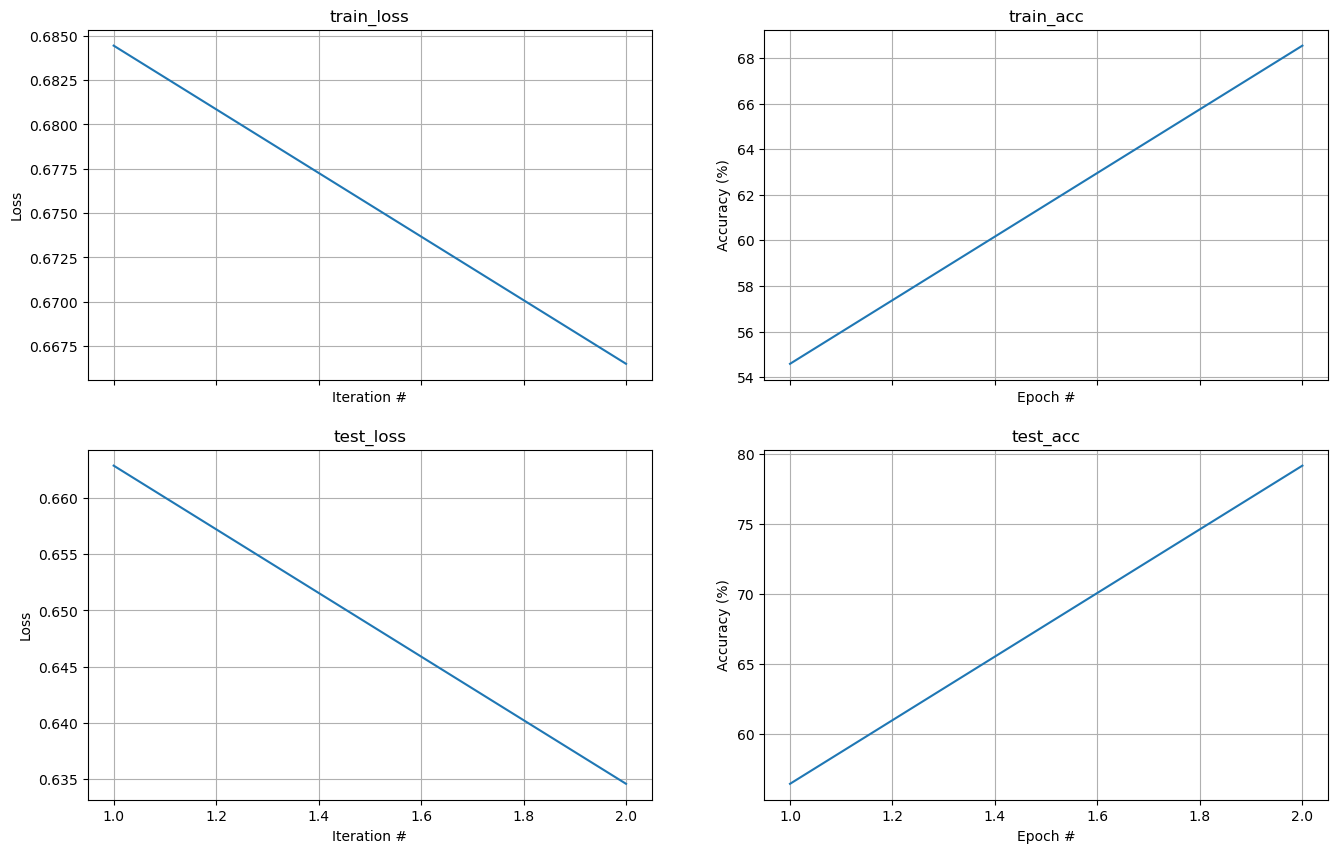

In [20]:
plot_fit(fit_result)

### Fine-tuning method 2 
__Retraining all the parameters in the model__

We will reload the model to ensure that the parameters are untouched and we are starting from scratch

In [21]:
from transformers import AutoModelForSequenceClassification


In [22]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [24]:
# TODO: Make sure all the model parameters are unfrozen
# ====== YOUR CODE: ======
for param in model.parameters():
    param.requires_grad = True
# ========================

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5)

# fit your model
if not os.path.exists('finetuned_all.pt'):
    trainer = training.FineTuningTrainer(model, loss_fn = None, optimizer = optimizer)
    fit_result = trainer.fit(dl_train,dl_test, checkpoints='finetuned_all', num_epochs=2, max_batches= 40)
    with open('finetuned_all.pkl', 'wb') as f:
        pickle.dump(fit_result, f)
    

saved_state = torch.load('finetuned_all.pt')
model.load_state_dict(saved_state['model_state']) 

with open('finetuned_all.pkl', 'rb') as f:
    fit_result = pickle.load(f)  


(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <Axes: title={'center': 'test_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'test_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

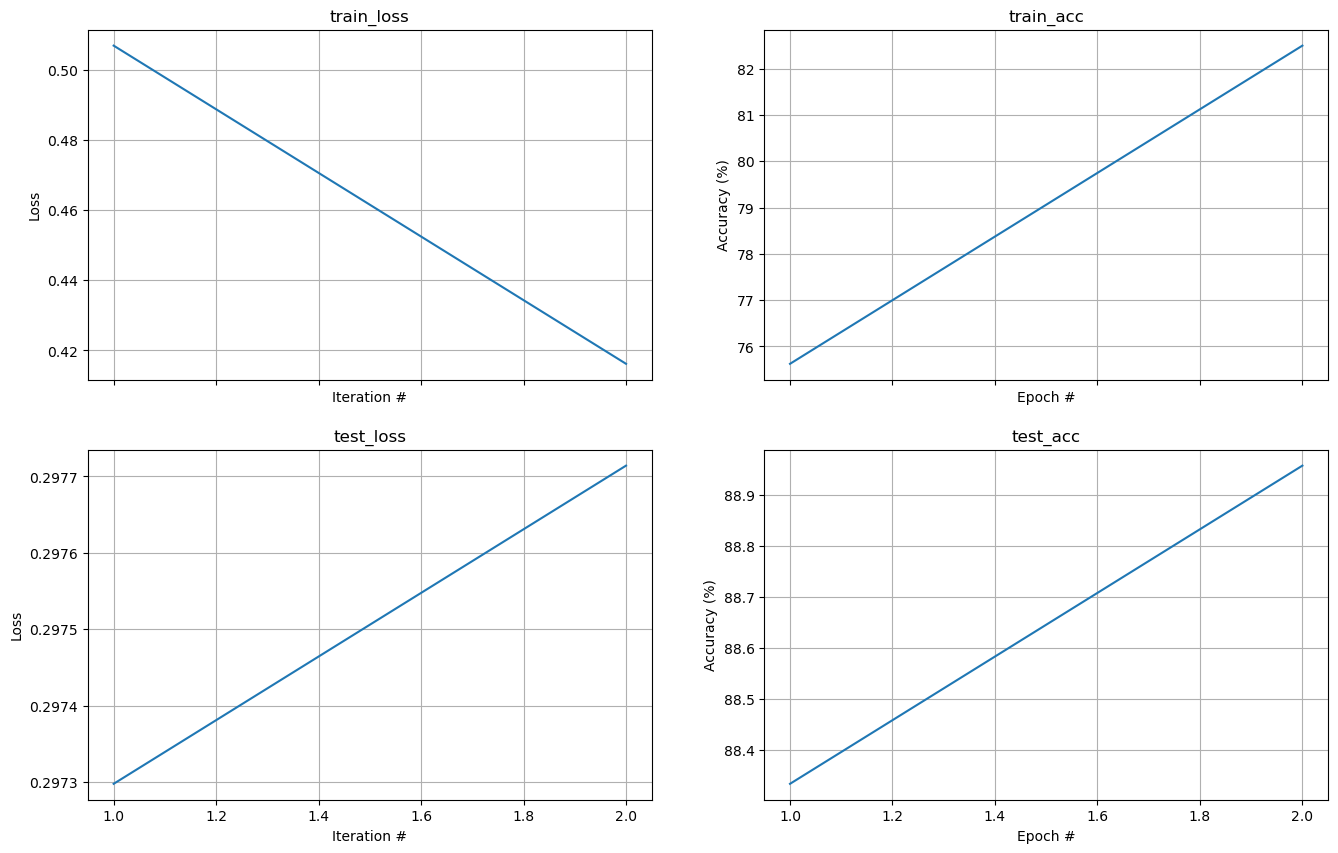

In [26]:
plot_fit(fit_result)

## Questions

Fill out your answers in `hw3.answers.part4_q1` and `hw3.answers.part4_q2`

In [1]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain the results that you got here in comparison to the results achieved in the *trained from scratch* encoder from the preivous part.  
If one of the models performed better, why was this so?   
Will this always be the case on any downstream task, or was this phenomenom specific to this task?


In [28]:
display_answer(hw3.answers.part4_q1)


**Your answer:**




### Question 2

Assume that when fine-tuning, instead of freezing the internal model layers and leaving the last 2 layers unfrozen, we instead froze the last layers and fine-tuned internal layers such as the multi-headed attention block .
Would the model still be able to succesfully fine-tune to this task?   
Or would the results be worse?  
Explain  

In [29]:
display_answer(hw3.answers.part4_q2)


If we were to fine-tune only the middle layers of a pre-trained model while freezing the last layers,
the results might be worse than the usual approach of fine-tuning the last layers.
The model's layers operate hierarchically, with the early and middle layers capturing basic relationships
and dependencies in the input data, and these relationships become more complex as we move deeper into the model.
This is similar to how convolutional layers in CNNs gradually capture more detailed features,
such as edges and textures progressing to more complex patterns. These early and middle layers help the model
build a general representation of the input, which can be useful across different tasks.

The last layers, however, are more specific to the task at hand and are designed to take these learned representations
and apply them to produce the desired output. If we fine-tune only the middle layers and freeze the last ones,
there could be a mismatch: the fine-tuned middle layers might generate updated representations of the input,
but the frozen last layers, which aren’t adapted to these changes, might not be able to
effectively use these new representations. This can lead to degraded performance because the final layers might not be
aligned with the new features learned by the middle layers.

That said, there are cases where fine-tuning the middle layers while keeping the last layers frozen could actually be 
beneficial. For example, in situations where there’s a significant shift in the data distribution, fine-tuning the
middle layers could help the model adapt to these changes by improving how the data is represented internally,
rather than just making adjustments at the classifier level in the final layers.




### Question 3

If you want to conduct a machine translation task, as seen in the tutorials, can you use BERT?

Describe the modulation you need to do, i.e. if the source tokens are $x_t$ and the target are $y_t$, how would the model work to produce the translation?

If the model can't handle this task, describe the architecture changes and why you need them. If a change in the pre-training is required, describe it as well.

In [30]:
display_answer(hw3.answers.part4_q3)


**Your answer:**




### Question 4

We saw in the course two types on sequntial modeling: RNN and Transformers.

What could be the main reason to choose RNN over a Transformer? Note that both can be light weight or heavy in computation.

In [31]:
display_answer(hw3.answers.part4_q4)


**Your answer:**




### Question 5

We have learned that BERT uses "Next Sentence Prediction" (NSP) as part of the pre-training tasks.

Describe what it is (where is the prediction accure, what is the loss).

Do you think this is a crucial part of pre-training? try to analize why you gave the answer, i.e. what essensity it gives to the model, or why it's implicitly don't contibute much. 


In [2]:
display_answer(hw3.answers.part4_q5)


Next Sentence Prediction (NSP) is one of the pre-training tasks used in BERT,
where the model is trained to predict whether two given sentences are consecutive in the original text.
During pre-training, BERT is provided with pairs of sentences—50% of the time, the second sentence is the actual
next sentence that follows the first in the corpus, labeled as "IsNext," while in the other 50% of cases,
the second sentence is a randomly selected sentence from the corpus, labeled as "NotNext."
The prediction occurs using the output of the [CLS] token, which is the first token in BERT’s input sequence and is
designed to aggregate information from the entire sequence. The loss function used for NSP is binary cross-entropy,
where the model predicts the probability that the second sentence is the true next sentence,
and the loss is calculated based on whether the model's prediction matches the true label.


We believe that NSP is not a crucial part of pre-training for BERT. Our reasoning is based on two key points:

Firstly, the authors of BERT included NSP as a pre-training task to help the model understand relationships
between sentences, which they believed was crucial for certain tasks like Question Answering (QA)
and Natural Language Inference (NLI). They assumed that the MLM task alone could not fully capture
the inter-sentence relationships needed for these tasks. However, follow-up research,
like that in RoBERTa, has shown that removing the NSP task did not harm—and in some cases even improved—performance
on downstream tasks. Moreover, DistilBERT (the model we use in our homework) also does not use NSP in pre-training,
suggesting that this task is not as essential as initially thought.

Secondly, we argue that NSP might indeed be redundant and potentially even confusing for the model.
The primary pre-training objective in BERT, MLM, already forces the model to learn rich contextual representations by
predicting masked words based on their surrounding context. This process inherently requires the model to understand
relationships between words and phrases, which often span across sentence boundaries. Therefore, MLM alone can capture
much of the inter-sentence coherence that NSP aims to address, making NSP redundant. Additionally,
the way NSP is implemented—by pairing sentences that either do or do not follow each other—creates an artificial setup. 
The negative examples, which are randomly selected sentences, do not necessarily represent meaningful alternatives
in natural language. This could lead the model to learn patterns that aren't actually useful for real-world tasks,
further questioning the utility of NSP in pre-training.

